In [1]:
import numpy as np
import random
import pygame as pg

random.randrange(10,50)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


45

In [2]:
from scipy.spatial import distance
import enum 
import copy 

class Object:
    def __init__(self, position):
        self.position = position
        
class State(enum.Enum):
    FIND_FOOD = 0
    GO_BACK = 1

class Organism(Object):
    PREDATOR_PREY_RATIO = 1.6
    SENSE_FACTOR = 1
    color = (255, 255, 255)
    food_found = 0
    state = State.FIND_FOOD
    energy = 0
    
    def __init__(self, size, speed, sense, max_w, max_h):
        # Organism starts at a border
        if random.random() > 0.5:
            x = random.uniform(0, max_w-1)
            y = 0
            if random.random() > 0.5:
                y = max_h-1
        else:
            y = random.uniform(0, max_h-1)
            x = 0
            if random.random() > 0.5:
                x = max_w-1
        super().__init__(np.array([x, y]))
        
        self.size = size
        self.speed = speed
        self.sense = sense
        
        self.max_w = max_w
        self.max_h = max_h
        
        direction = [np.random.uniform(-1,1), np.random.uniform(-1,1)]
        
        self.direction = direction/np.linalg.norm(direction)   
        
        
    def energy_cost(self):
        return ((self.size**3)*self.speed**2)+self.sense
    
    def get_coordinates(self):
        return self.position
    
    def reproduce(self, energy):
        offspring = copy.deepcopy(self)
        mutation_chance = 0.1
        
        #offspring.size  += (mutation_chance>random.random())*0.1*random.choice([-1,1])#self.size *random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        #offspring.speed += (mutation_chance>random.random())*0.1*random.choice([-1,1])#*self.speed*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        #offspring.sense += (mutation_chance>random.random())*0.1*random.choice([-1,1])#*self.sense*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        
        offspring.size  += (mutation_chance>random.random())*random.uniform(0.1, 0.5)*random.choice([-1,1])#self.size *random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.speed += (mutation_chance>random.random())*random.uniform(0.1, 0.5)*random.choice([-1,1])#*self.speed*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.sense += (mutation_chance>random.random())*random.uniform(0.1, 0.5)*random.choice([-1,1])#*self.sense*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        
        
        offspring.energy = energy      
        offspring.state = State.FIND_FOOD
        
        return offspring
    
    def attributes(self):
        return np.array([self.size, self.speed, self.sense])
    
    def closest_border(self):
        borders = [[self.position[0], 0], [self.max_w, self.position[1]], [self.position[0], self.max_h],[0, self.position[1]]]
        distances = distance.cdist([self.get_coordinates()], borders, 'euclidean')[0]
        closest_idx = np.argmin(distances)
        
        return distances[closest_idx], borders[closest_idx][0], borders[closest_idx][1]
    
    def can_eat(self, other):
        return self.size>= self.PREDATOR_PREY_RATIO*other.size
    
    def walk(self, env, indexKD):
        distances = []
        step_size = self.speed
        direction = self.direction
        
        food = []
        close_predators = []
        close_obj_idx = indexKD.query_ball_point(self.position, self.sense * self.SENSE_FACTOR)
        
        for obj in np.array(env)[close_obj_idx]:
            if obj == self: continue
            if not isinstance(obj, Organism): food.append(obj.position)
            elif self.can_eat(obj):
                food.append(obj.position)
            elif obj.can_eat(self):
                close_predators.append(obj.position)
                                
        if len(food) > 0:
            distances = distance.cdist([self.position], food, 'euclidean')[0]
            closest_idx = np.argmin(distances)
            
        if len(close_predators) > 0:
            pr_distances = distance.cdist([self.position], close_predators, 'euclidean')[0]
            pr_idx = np.argmin(pr_distances)
            
            d = (close_predators[pr_idx] + self.position)*-1
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm 
            #print("RUN!")
        
        elif self.state == State.GO_BACK:
            dist, x, y = self.closest_border()
            step_size = dist if abs(dist) < step_size else step_size
            
            d = np.array([x, y]) - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm   
        elif (len(distances) > 0) and (distances[closest_idx] <= (self.sense * self.SENSE_FACTOR)):
            step_size = distances[closest_idx] if abs(distances[closest_idx]) < step_size else step_size
            
            d = food[closest_idx] - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm           
        else:            
            #x2=cosβx1−sinβy1, y2=sinβx1+cosβy1
            
            r = random.uniform(-.5, .5)#(-np.pi/2, np.pi/2)
            direction = np.array([np.cos(r)*direction[0] - np.sin(r)*direction[1], 
                                  np.sin(r)*direction[0] + np.cos(r)*direction[1]])
            self.direction = direction/np.linalg.norm(direction)
        
        if self.energy >= self.energy_cost():
            self.position += step_size*direction
        
        self.energy -= self.energy_cost()   
    

In [7]:
import numpy as np
import random
import pygame as pg
from pygame.locals import *
from scipy.spatial import cKDTree
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
#matplotlib.use("Agg")

import matplotlib.backends.backend_agg as agg
import pylab

SCREEN_WIDTH, SCREEN_HEIGHT = 800,600
ENV_WIDTH, ENV_HEIGHT = 100, 80

BACK_COLOR = (100, 100, 100)

BLOCK_SIZE = 5  # Pixel size

ENV_WIDTH_PX = BLOCK_SIZE * ENV_WIDTH 
ENV_HEIGHT_PX = BLOCK_SIZE * ENV_HEIGHT 
ENV_TOP_LEFT_CORNER = (SCREEN_WIDTH // 2 - ENV_WIDTH_PX // 2, SCREEN_HEIGHT // 2 - ENV_HEIGHT_PX // 2)

MINUTES_PER_DAY = 100
DAY_ENERGY = 25*MINUTES_PER_DAY
REMOVE_EXCESS_FOOD = True

INITIAL_POPULATION_COMPOSITION = [
    (2, (1, 3, 5)), 
    (1, (2, 1.5, 5)),
    (1, (1, 2, 10))
]

FOOD_INITIAL_AMOUNT = 50
FOOD_DECREASE = True
FOOD_DECREASE_RATE = 0.1 # %
FOOD_DECREASE_TIME = 10  # days

SHOW_PLOTS = False

screen = None

def init_organisms(n, attr):
    organisms = []
    for _ in range(n):
        o = Organism(attr[0], attr[1], attr[2], ENV_WIDTH, ENV_HEIGHT)
        o.energy = DAY_ENERGY
        organisms.append(o)
    return organisms


def draw(color, x, y, factor = 1):
    pg.draw.rect(screen, color, (x, y, factor*BLOCK_SIZE, factor*BLOCK_SIZE))

def draw_environment(screen, env):
        screen.fill(BACK_COLOR)
        pg.draw.rect(screen, (0,0,0), (ENV_TOP_LEFT_CORNER[0], ENV_TOP_LEFT_CORNER[1],
                                               ENV_WIDTH_PX, ENV_HEIGHT_PX))
        draw_xy, color = np.array([0,0]), None
        for o in env:
            color = (0,255,0) if not isinstance(o, Organism) else o.color 
            draw_xy = o.position*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            factor = 1 if not isinstance(o, Organism) else o.size
            draw(color, draw_xy[0], draw_xy[1], factor)

def kill(env):
    kill_counter = 0
    
    for o in env.copy():
        if not isinstance(o, Organism): continue
        dist_to_border, _, _ = o.closest_border()
        if (o.energy <= 0) or (dist_to_border > 1):
            env.remove(o)
            kill_counter += 1
    #print("{} organisms killed".format(kill_counter))
            
            
def sleep_and_reproduce(env):
    babies = []
    for o in env:
        if not isinstance(o, Organism): continue
        if o.food_found >= 2:
            babies.append(o.reproduce(DAY_ENERGY))
        o.food_found = 0
        o.energy = DAY_ENERGY
        o.state = State.FIND_FOOD
    env.extend(babies)
    #print("{} babies born".format(len(babies)))
                
def do_one_step(env, m):    
    minutes_left = MINUTES_PER_DAY - m
    
    attributes = np.array([o.attributes() for o in env if isinstance(o, Organism)])
    max_attr = np.max(attributes)
    
    env_copy = env.copy()
    
    coords = np.array([o.position for o in env])
    indexKD = cKDTree(coords, leafsize=16)
    
    for o in env:
        if not isinstance(o, Organism): continue
        o.walk(env, indexKD)
    
    coords = np.array([o.position for o in env])
    indexKD = cKDTree(coords, leafsize=16)
    for o in env_copy:
        if not isinstance(o, Organism): continue    
        close_obj_idx = indexKD.query_ball_point(o.position, o.sense*o.SENSE_FACTOR)
        #print(close_obj_idx)
        #if len(close_obj_idx) == 0: continue
        for obj in np.array(env_copy)[close_obj_idx]:
            if obj == o: continue
            if not np.linalg.norm(obj.position-o.position) <= 0.01: continue
            if not isinstance(obj, Organism) or o.can_eat(obj):
                if obj in env:
                    env.remove(obj)
                    o.food_found += 1
                    dist_to_border, _, _ = o.closest_border()
                    if (o.food_found > 1) or (dist_to_border/o.speed >= minutes_left-5):
                        o.state = State.GO_BACK
                    break
            
        pos = o.get_coordinates()%np.array([ENV_WIDTH+1, ENV_HEIGHT+1])
        #min(max(x,0),ENV_WIDTH-1)
        #min(max(y,0), ENV_HEIGHT-1)
        o.position = pos
        o.color = o.attributes()*255/max_attr
                
def run_simulation(num_days=None, display=True):
    if not display and not num_days:
        num_days = 100
    if display:
        global screen
        pg.init()
        screen = pg.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pg.display.update()
    
    raw_data = canvas = None
    env = []
    n_food = FOOD_INITIAL_AMOUNT
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env.append(Object(np.array([x, y])))
    
    for n, org in INITIAL_POPULATION_COMPOSITION:
        env.extend(init_organisms(n, org))
    
    # Main game loop
    run = True
    
    time_keeper = {"day":0, "minute":0}
    attributes = np.array([o.attributes() for o in env if isinstance(o, Organism)])
    stats = {"population":[len(attributes)], "attributes":[attributes], "food": [n_food]}
    while run:
        if display:
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    run = False
        
        if len([o for o in env if isinstance(o, Organism)]) == 0:
            run = False
            continue
        
        if num_days and time_keeper["day"] >= num_days:
            run = False
            continue
            
        ## Create figures
        if time_keeper["minute"] == 0:
            if len(attributes) > 0:
                
                fig = pylab.figure(figsize=[1.5, 2], # Inches
                       dpi=100,        # 100 dots per inch, so the resulting buffer is 400x400 pixels
                       )
                ax = fig.gca()
                max_attr = np.max(attributes)
                si = attributes[:,0]
                sp = attributes[:,1]
                se = attributes[:,2]
                bin_size = 0.1
                bins = np.arange(0,np.ceil(max_attr), bin_size)
                hist_si, edges = np.histogram(si, bins=bins)
                hist_sp, edges = np.histogram(sp, bins=bins)
                hist_se, edges = np.histogram(se, bins=bins)
                #fig = plt.figure()
                ax.bar(bins[:-1], hist_si, width=bin_size, align='edge', alpha=.5)
                ax.bar(bins[:-1], hist_sp, width=bin_size, align='edge', alpha=.5)
                ax.bar(bins[:-1], hist_se, width=bin_size, align='edge', alpha=.5)
                ax.legend(["size", "speed", "sense"])
                #ax.show()

                canvas = agg.FigureCanvasAgg(fig)
                canvas.draw()
                renderer = canvas.get_renderer()
                raw_data = renderer.tostring_rgb()
                plt.close('all')
        
        # do one simulation step
        do_one_step(env, time_keeper["minute"])
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= MINUTES_PER_DAY:
            print("Day {} is over.".format(time_keeper["day"]))
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill(env)
            sleep_and_reproduce(env)
            
            if FOOD_DECREASE and time_keeper["day"]%FOOD_DECREASE_TIME == 0:
                n_food = int(n_food*(1-FOOD_DECREASE_RATE))
                print("decreased food to {}".format(n_food))
            if REMOVE_EXCESS_FOOD:
                for i, o in enumerate(env):
                    if not isinstance(o, Organism):
                        env.pop(i)
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env.append(Object(np.array([x, y])))
            
            if display:
                pg.time.wait(500)
            
            attributes = np.array([o.attributes() for o in env if isinstance(o, Organism)])
            
            ## Save stats
            stats["population"].append(len(attributes))
            stats["food"].append(n_food)
            if len(stats["attributes"]) > 0:
                stats["attributes"].append(attributes)            
        
        if display:
            draw_environment(screen, env)
            if SHOW_PLOTS and raw_data:
                surf = pg.image.fromstring(raw_data, canvas.get_width_height(), "RGB")
                screen.blit(surf, (0,0))
            
            pg.display.update()
            pg.time.wait(10)
            pg.event.pump()

    pg.quit()
    return stats
    
stats = run_simulation(display=True)

Day 0 is over.


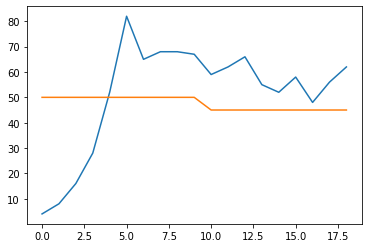

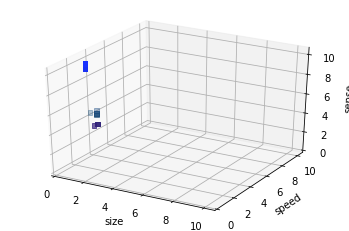

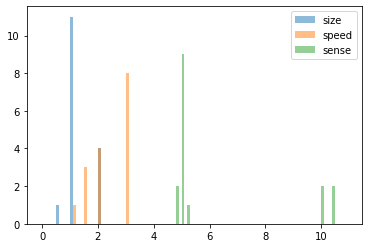

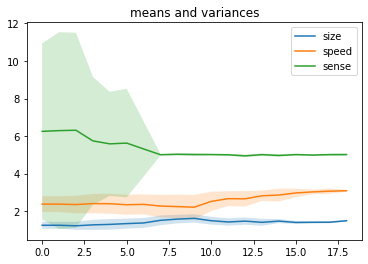

In [189]:
%matplotlib inline
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting

fig = plt.figure()
plt.plot(np.arange(0,len(stats["population"])), stats["population"])
plt.plot(np.arange(0,len(stats["food"])), stats["food"])
#plt.plot(np.arange(0,len(stats["n_clusters"])), 25*np.array(stats["n_clusters"]))
plt.show()

#print(len(stats["attributes"]))
atts = np.array(stats["attributes"][2])#[len(stats["attributes"])-2])

si = atts[:,0] 
sp = atts[:,1]
se = atts[:,2]
max_attr = np.max([np.max(attrs) for attrs in stats["attributes"] if len(attrs) > 0])
colors = np.array(atts/max_attr)

fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.scatter(xs=si,ys=sp,zs=se, c = colors, marker = "s")
plt.xlim(0, max_attr)
plt.ylim(0, max_attr)
ax.set_zlim(0, max_attr)
ax.set_xlabel("size")
ax.set_ylabel("speed")
ax.set_zlabel("sense")
plt.show()

bin_size = 0.1
bins = np.arange(0,np.ceil(max_attr), bin_size)
hist_si, edges = np.histogram(si, bins=bins)
hist_sp, edges = np.histogram(sp, bins=bins)
hist_se, edges = np.histogram(se, bins=bins)
fig = plt.figure()
plt.bar(bins[:-1], hist_si, width=bin_size, align='edge', alpha=.5)
plt.bar(bins[:-1], hist_sp, width=bin_size, align='edge', alpha=.5)
plt.bar(bins[:-1], hist_se, width=bin_size, align='edge', alpha=.5)
plt.legend(["size", "speed", "sense"])
plt.show()

#print([atts.shape for atts in stats["attributes"]])
means = np.array([[np.mean(np.array(atts)[:,0]), np.mean(np.array(atts)[:,1]), np.mean(np.array(atts)[:,2])] if len(atts) > 1 else atts[0,:] for atts in stats["attributes"]])
variances =  np.array([[np.var(np.array(atts)[:,0]),  np.var(np.array(atts)[:,1]),  np.var(np.array(atts)[:,2])] if len(atts) > 1 else [0, 0, 0] for atts in stats["attributes"]])

fig = plt.figure()
plt.plot(np.arange(0,len(means)), means[:,0])
plt.fill_between(np.arange(0,len(means)),means[:,0]-variances[:,0],means[:,0]+variances[:,0],alpha=.2)

plt.plot(np.arange(0,len(means)), means[:,1])
plt.fill_between(np.arange(0,len(means)),means[:,1]-variances[:,1],means[:,1]+variances[:,1],alpha=.2)

plt.plot(np.arange(0,len(means)), means[:,2])
plt.fill_between(np.arange(0,len(means)),means[:,2]-variances[:,2],means[:,2]+variances[:,2],alpha=.2)

plt.legend(["size", "speed", "sense"])
plt.title("means and variances")
plt.show()

In [6]:
import pickle
with open('stats_1570799946.7791488.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
print(b)

{'population': [4, 8, 16, 30, 58, 78, 65, 64, 53], 'attributes': [array([[ 1. ,  3. ,  5. ],
       [ 1. ,  3. ,  5. ],
       [ 2. ,  1.5,  5. ],
       [ 1. ,  2. , 10. ]]), array([[ 1.        ,  3.        ,  5.        ],
       [ 1.        ,  3.        ,  5.        ],
       [ 2.        ,  1.5       ,  5.        ],
       [ 1.        ,  2.        , 10.        ],
       [ 1.        ,  3.        ,  5.        ],
       [ 1.        ,  2.65609619,  5.        ],
       [ 2.        ,  1.5       ,  5.        ],
       [ 1.        ,  2.        , 10.        ]]), array([[ 1.        ,  3.        ,  5.        ],
       [ 1.        ,  3.        ,  5.        ],
       [ 2.        ,  1.5       ,  5.        ],
       [ 1.        ,  2.        , 10.        ],
       [ 1.        ,  3.        ,  5.        ],
       [ 1.        ,  2.65609619,  5.        ],
       [ 2.        ,  1.5       ,  5.        ],
       [ 1.        ,  2.        , 10.        ],
       [ 1.        ,  3.        ,  5.        ],
      

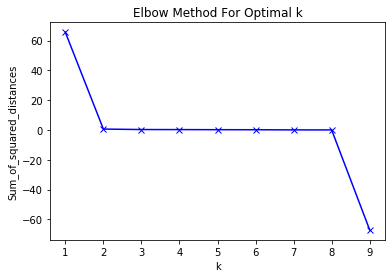

There are 2 organism clusters here


In [81]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = stats["attributes"][2]#[len(stats["attributes"])-2]

Sum_of_squared_distances = []
K = range(1,min(10, len(data)))
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances-np.roll(Sum_of_squared_distances, -1), 'bx-')
#plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

N_clusters = 1 + np.where(Sum_of_squared_distances-np.roll(Sum_of_squared_distances, -1)<4)[0][0]
print("There are {} organism clusters here".format(N_clusters))


[[1.  3.  5. ]
 [2.  1.5 2. ]]


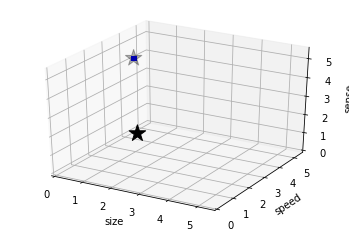

In [63]:
data = stats["attributes"][0]#[len(stats["attributes"])-1]
max_attr = np.max([np.max(attrs) for attrs in stats["attributes"]])
colors = np.array(atts/max_attr)
km = KMeans(n_clusters=2)
km = km.fit(data)
centers = km.cluster_centers_
print(centers)

fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.scatter(xs=data[:, 0], ys=data[:, 1], zs=data[:, 2], c = "blue", marker = "s")
ax.scatter(xs=centers[:, 0], ys=centers[:, 1], zs=centers[:, 2], c="black", marker = "*", s=300)
plt.xlim(0, max_attr)
plt.ylim(0, max_attr)
ax.set_zlim(0, max_attr)
ax.set_xlabel("size")
ax.set_ylabel("speed")
ax.set_zlabel("sense")
plt.show()


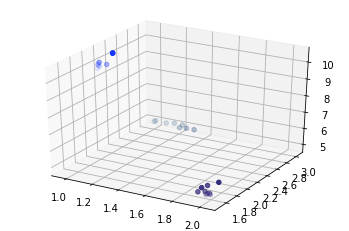

In [117]:
stats["cluster_centers"] = []
for atts in np.array(stats["attributes"]):
    ssd = []
    K = range(1,min(10, len(np.unique(atts))-2))
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(atts)
        ssd.append(km.inertia_)
    best_k = 1 + np.where((ssd-np.roll(ssd, -1))<4)[0][0]
    km = KMeans(n_clusters=best_k)
    km = km.fit(atts)
    stats["cluster_centers"].append(km.cluster_centers_)

centers = stats["cluster_centers"]
#print(centers)
max_attr = np.max([np.max(attrs) for attrs in centers if len(attrs) > 0])
#alphas = np.flip(np.linspace(0.1, 1, len(centers)))
alphas = np.linspace(0.1, 1, len(centers))

fig2 = plt.figure()
ax = fig2.gca(projection='3d')
for i, cc in enumerate(centers):
    rgb = np.array(cc/max_attr)
    rgba = np.zeros((len(rgb), 4))
    rgba[:,:3] = rgb
    rgba[:,3] = alphas[i]
    
    ax.scatter(cc[:,0], cc[:,1], cc[:,2], color=rgba)
plt.show()

[[ 1.          2.         10.        ]
 [ 1.          2.03050048 10.07503855]
 [ 0.97619171  2.06344141 10.09004626]
 [ 1.02680448  2.1003136  10.1000514 ]
 [ 0.96359763  2.1128528  10.11255783]
 [ 1.          2.26840832 10.45023132]
 [ 1.          2.26840832 10.45023132]
 [ 1.          2.26840832 10.45023132]
 [ 1.          2.26840832 10.45023132]
 [        nan         nan         nan]]


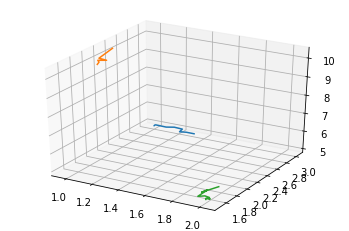

In [173]:
max_n_clusters = np.max([len(c) for c in centers])

clusters ={}
for i in range(max_n_clusters):
    clusters[i] = []
    
for t, cc in enumerate(centers):
    for i in range(max_n_clusters):
        clusters[i].append(np.array([float('NaN'), float('NaN'), float('NaN')]))
    for i, center in enumerate(cc):
        closest_cluster = i
        closest_distance = 999
        if t > 0:
            for j in range(max_n_clusters):
                dist = np.linalg.norm(clusters[j][-2]-center)
                if dist < closest_distance:
                    closest_distance = dist
                    closest_cluster = j
        clusters[closest_cluster][-1] = np.array(center)

        
print(np.array(clusters[1]))
alphas = np.linspace(0.1, 1, len(centers))

fig2 = plt.figure()
ax = fig2.gca(projection='3d')
for c in clusters.keys():
    cc = np.array(clusters[c])    
    ax.plot(cc[:,0], cc[:,1], cc[:,2])#, alpha=alphas)
    
plt.show()

Minuntes per day: 100
Energy per day: 2500
So energy per minute: 25.0
An organism that uses every minute of the day to find food can spend 25.0 per minute
This means that if speed and sense are 1, size = log(24.0)/log(3) = 2.9299470414358537
This means that if size and sense are 1, speed = log(24.0)/log(2) = 4.643856189774724


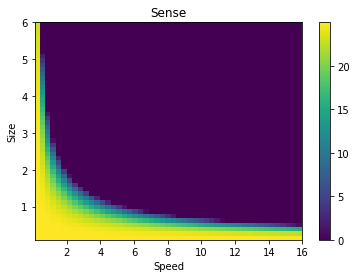

In [54]:
%matplotlib inline

print("Minuntes per day:", MINUTES_PER_DAY)
print("Energy per day:", DAY_ENERGY)
print("So energy per minute:", DAY_ENERGY/MINUTES_PER_DAY)

print("An organism that uses every minute of the day to find food can spend {} per minute".format(DAY_ENERGY/MINUTES_PER_DAY))
print("This means that if speed and sense are 1, size = log({})/log(3) = {}".format(DAY_ENERGY/MINUTES_PER_DAY -1, np.log(DAY_ENERGY/MINUTES_PER_DAY)/np.log(3)))
print("This means that if size and sense are 1, speed = log({})/log(2) = {}".format(DAY_ENERGY/MINUTES_PER_DAY -1, np.log(DAY_ENERGY/MINUTES_PER_DAY)/np.log(2)))

speeds = np.linspace(0.1, 16, 50)
sizes = np.linspace(0.1, 6, 50)

X, Y = np.meshgrid(speeds, sizes)
Z = ((25-((Y**3)*X**2))).clip(min=0)



# Plot the surface.
fig = plt.figure()
plt.pcolormesh(X,Y,Z)
plt.colorbar()
plt.xlabel("Speed")
plt.ylabel("Size")
plt.title("Sense")

plt.show()

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y, Z = np.mgrid[0.5:5:0.1, 0.5:10:0.1, 0.5:10:0.1]

T = ((X**3)*(Y**2) + Z)<=30

<IPython.core.display.Javascript object>


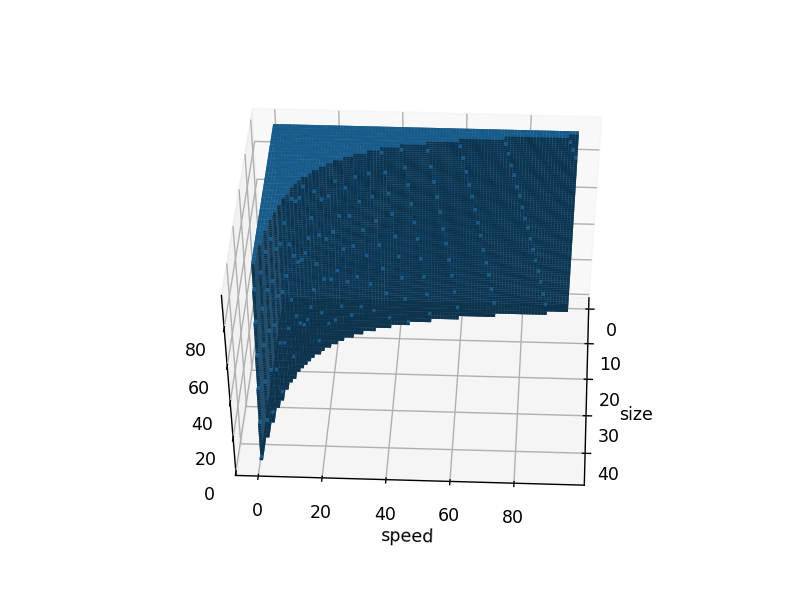

In [9]:
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')
ax.voxels(T)
plt.xlabel("size")
plt.ylabel("speed")
plt.show()